#Przegląd

https://www.cloudskillsboost.google/focuses/1797?parent=catalog

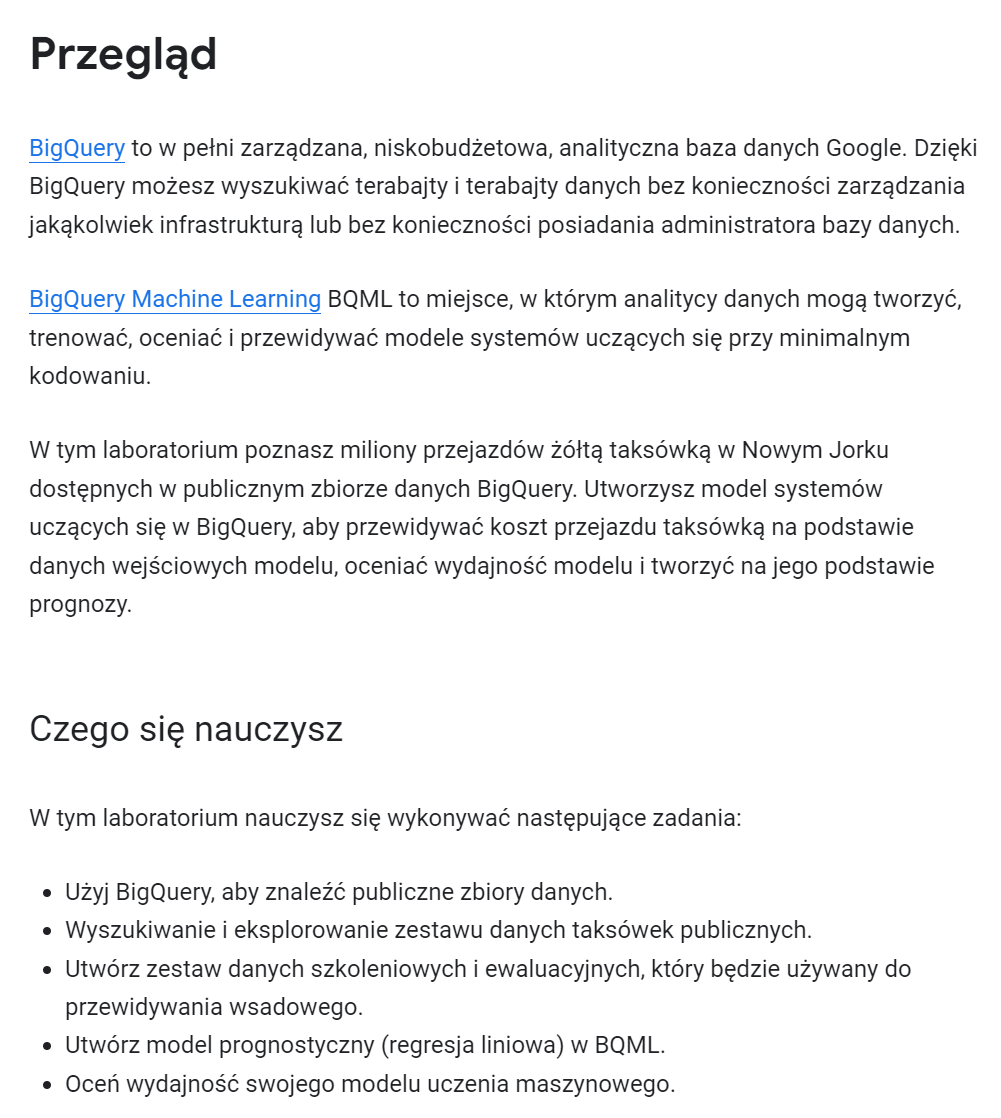

#Zadanie 1

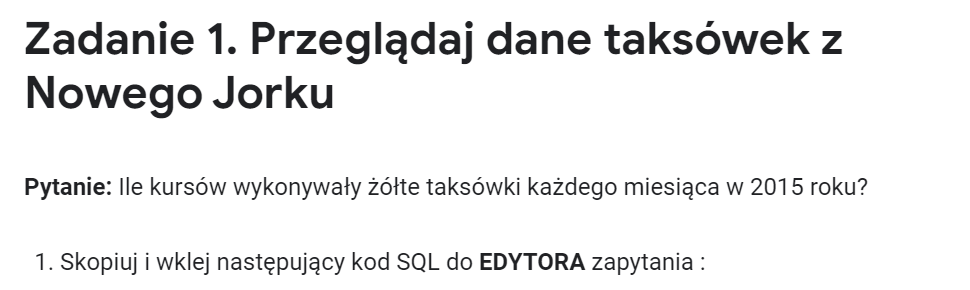

In [ ]:
%%bigquery

SELECT
  TIMESTAMP_TRUNC(pickup_datetime, MONTH) month,
  COUNT(*) trips
FROM
  `bigquery-public-data.new_york.tlc_yellow_trips_2015`
GROUP BY
  1
ORDER BY
  1

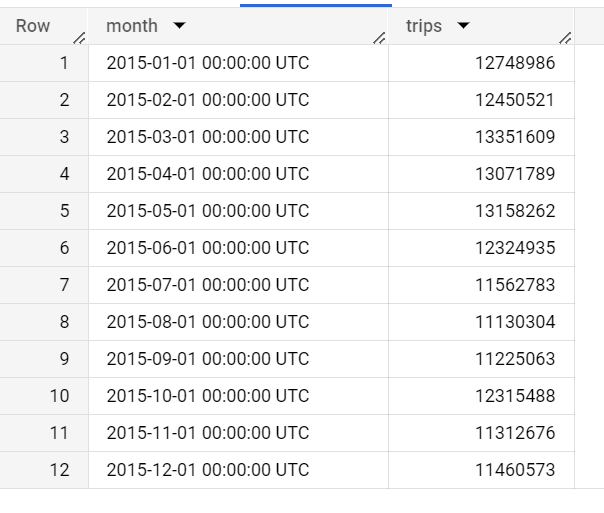

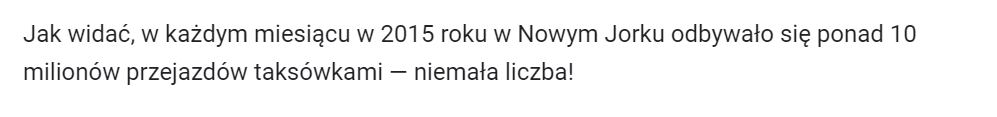

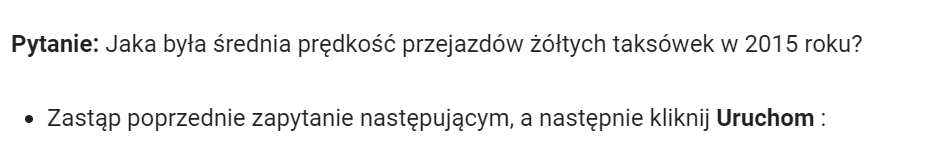

In [ ]:
%%bigquery

SELECT
  EXTRACT(HOUR FROM pickup_datetime) hour,
  ROUND(AVG(trip_distance / TIMESTAMP_DIFF(dropoff_datetime, pickup_datetime, SECOND))*3600, 1) speed
FROM
  `bigquery-public-data.new_york.tlc_yellow_trips_2015`
WHERE
  trip_distance > 0
  AND fare_amount/trip_distance BETWEEN 2 AND 10
  AND dropoff_datetime > pickup_datetime
GROUP BY
  1
ORDER BY
  1

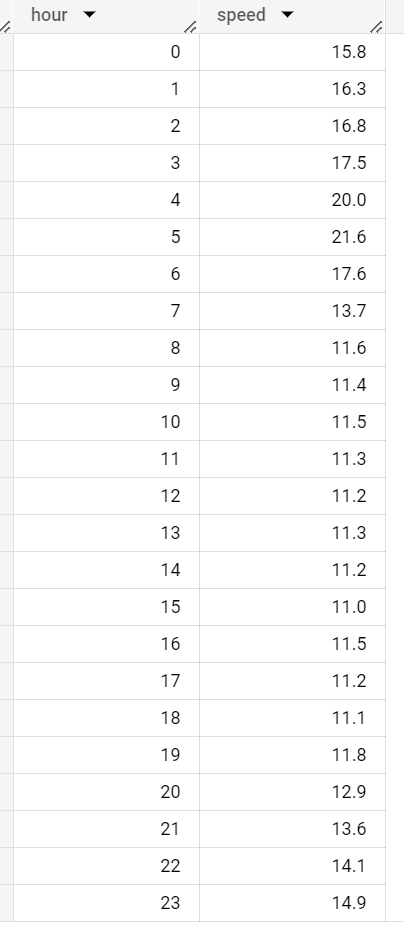

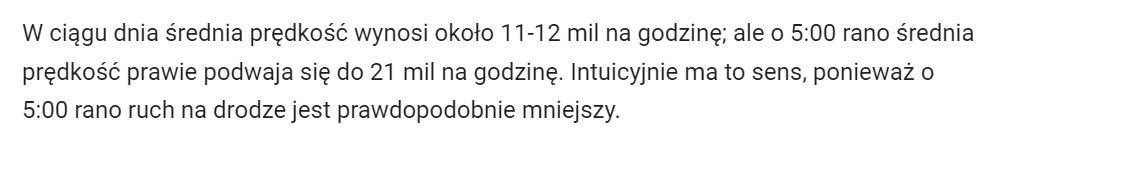

#Zadanie 2

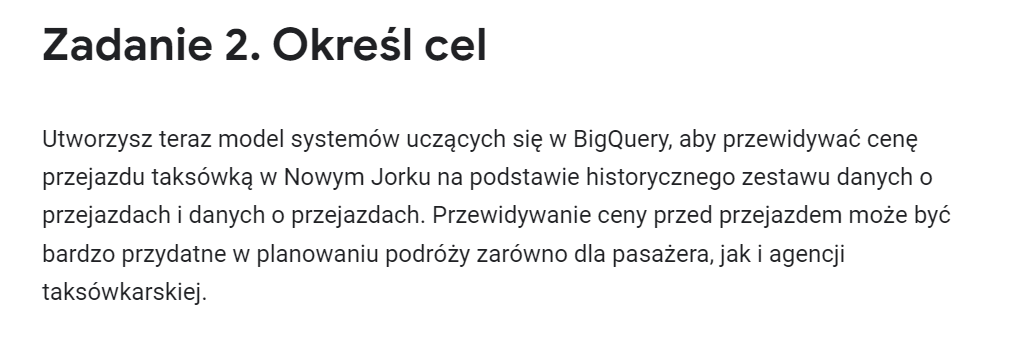

#Zadanie 3 Dane treningowe

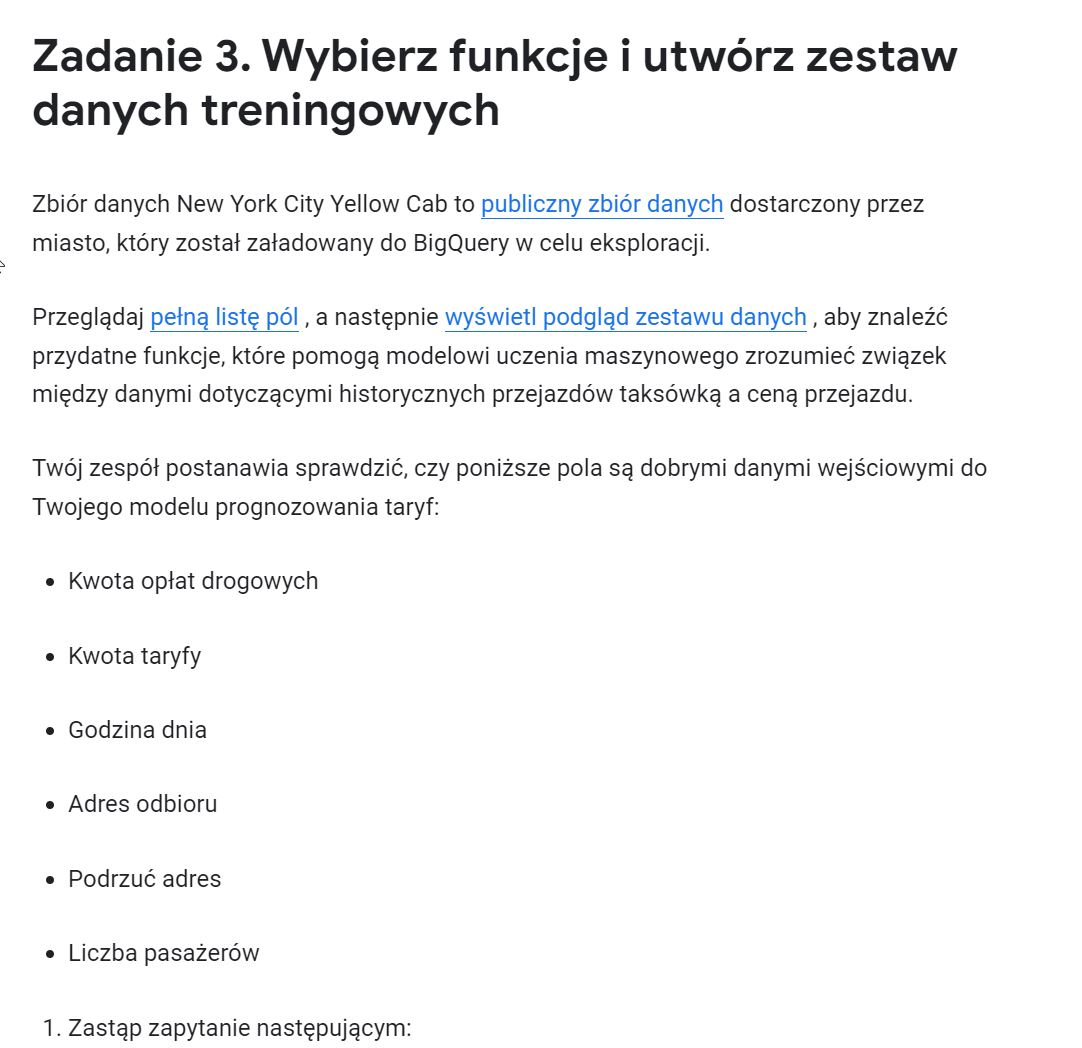

In [ ]:
%%bigquery

WITH params AS (
    SELECT
    1 AS TRAIN,
    2 AS EVAL
    ),

  daynames AS
    (SELECT ['Sun', 'Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat'] AS daysofweek),

  taxitrips AS (
  SELECT
    (tolls_amount + fare_amount) AS total_fare,
    daysofweek[ORDINAL(EXTRACT(DAYOFWEEK FROM pickup_datetime))] AS dayofweek,
    EXTRACT(HOUR FROM pickup_datetime) AS hourofday,
    pickup_longitude AS pickuplon,
    pickup_latitude AS pickuplat,
    dropoff_longitude AS dropofflon,
    dropoff_latitude AS dropofflat,
    passenger_count AS passengers
  FROM
    `nyc-tlc.yellow.trips`, daynames, params
  WHERE
    trip_distance > 0 AND fare_amount > 0

    # Klauzula pobierania próbek, aby zebrać tylko 1/1000 danych
    # Zdefiniuj zmienną o nazwie TRAIN, aby móc szybko zbudować niezależny EVAL zestaw
    AND MOD(ABS(FARM_FINGERPRINT(CAST(pickup_datetime AS STRING))),1000) = params.TRAIN
  )

  SELECT *
  FROM taxitrips

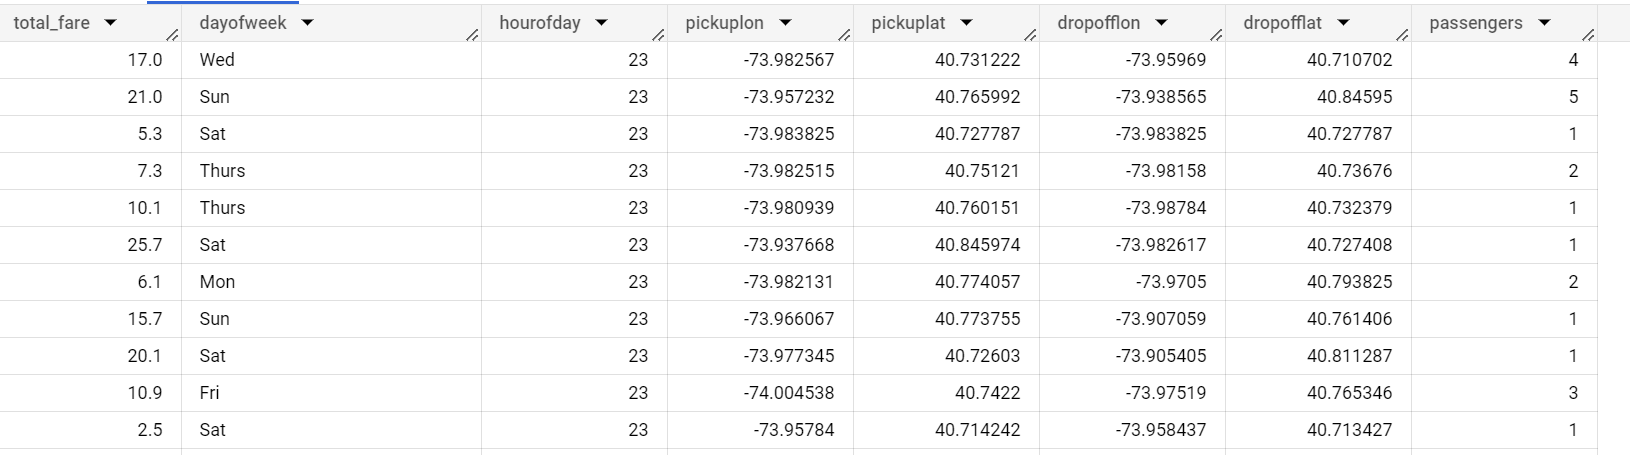

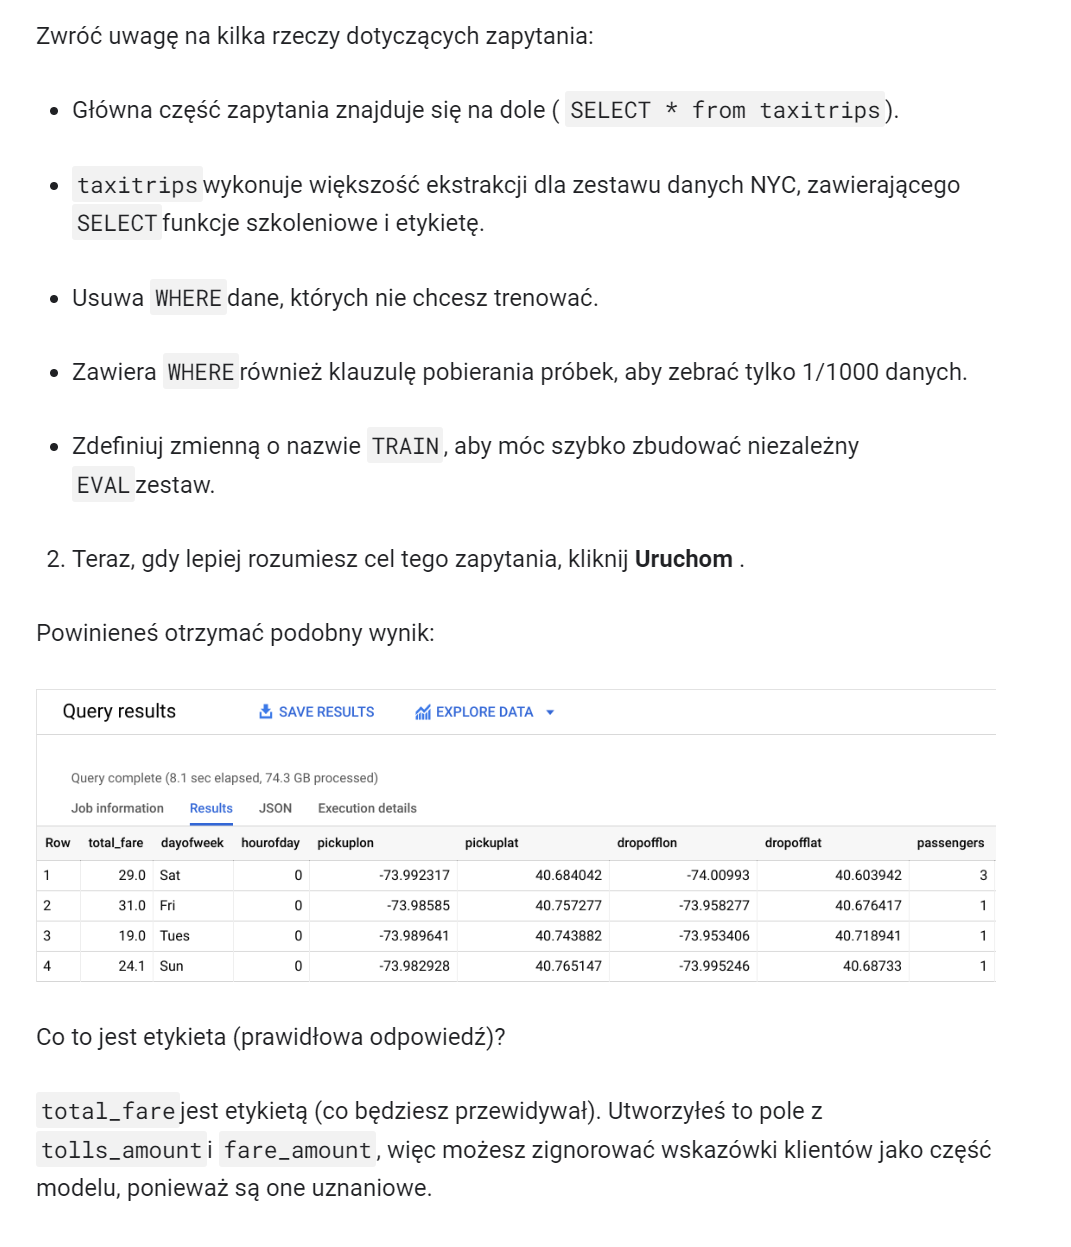

#Zadanie 4. Utwórz zbiór danych BigQuery do przechowywania modeli

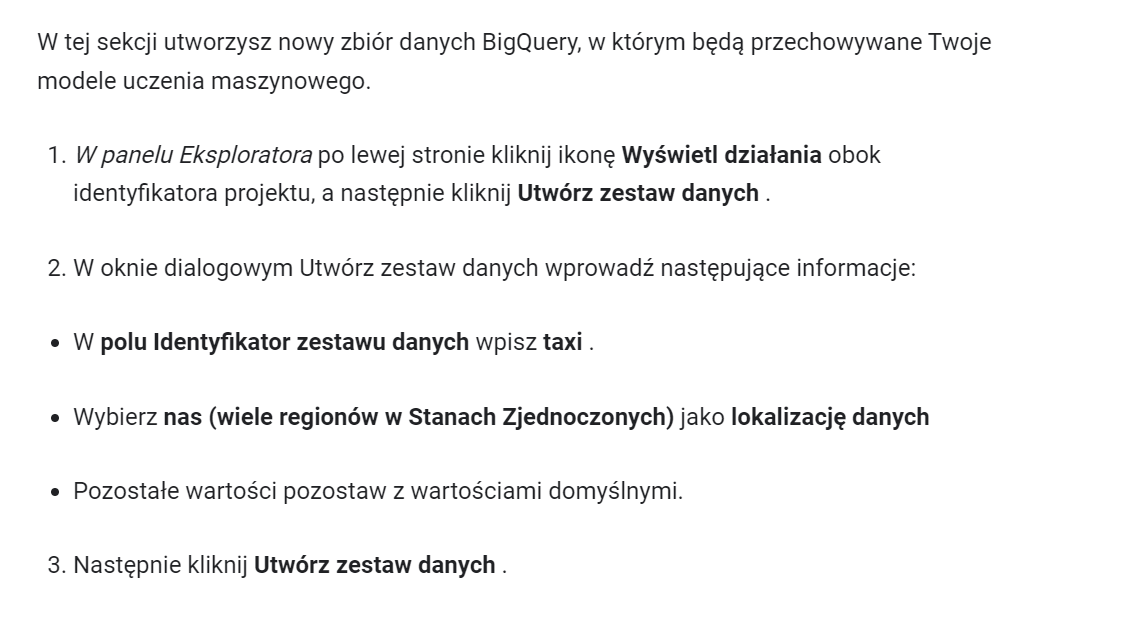

#Zadanie 5. Wybierz typ modelu BigQuery ML i określ opcje

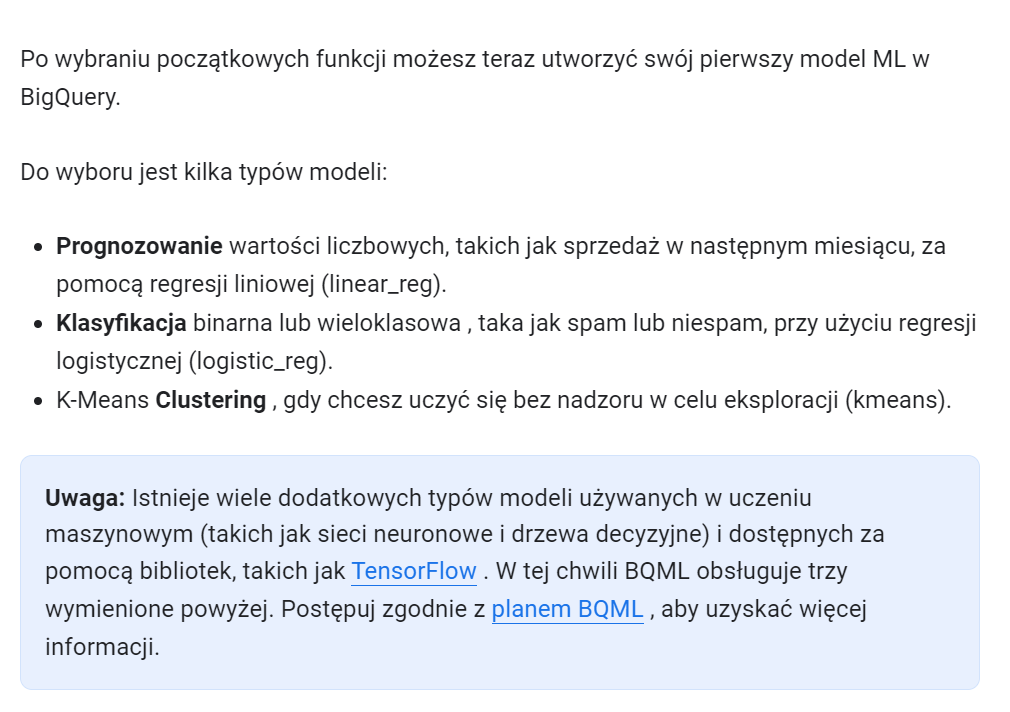

https://cloud.google.com/bigquery/docs/reference/standard-sql/bigqueryml-syntax-create

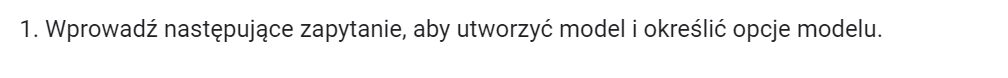

In [ ]:
%%bigquery

CREATE or REPLACE MODEL taxi.taxifare_model
OPTIONS
  # (model_type='linear_reg', labels=['total_fare']) AS
  (model_type='linear_reg', INPUT_LABEL_COLS=['total_fare']) AS

WITH params AS (
    SELECT
    1 AS TRAIN,
    2 AS EVAL
    ),
  daynames AS
    (SELECT ['Sun', 'Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat'] AS daysofweek),
  taxitrips AS (
  SELECT
    (tolls_amount + fare_amount) AS total_fare,
    daysofweek[ORDINAL(EXTRACT(DAYOFWEEK FROM pickup_datetime))] AS dayofweek,
    EXTRACT(HOUR FROM pickup_datetime) AS hourofday,
    pickup_longitude AS pickuplon,
    pickup_latitude AS pickuplat,
    dropoff_longitude AS dropofflon,
    dropoff_latitude AS dropofflat,
    passenger_count AS passengers
  FROM
    `nyc-tlc.yellow.trips`, daynames, params
  WHERE
    trip_distance > 0 AND fare_amount > 0
    AND MOD(ABS(FARM_FINGERPRINT(CAST(pickup_datetime AS STRING))),1000) = params.TRAIN
  )
  SELECT *
  FROM taxitrips

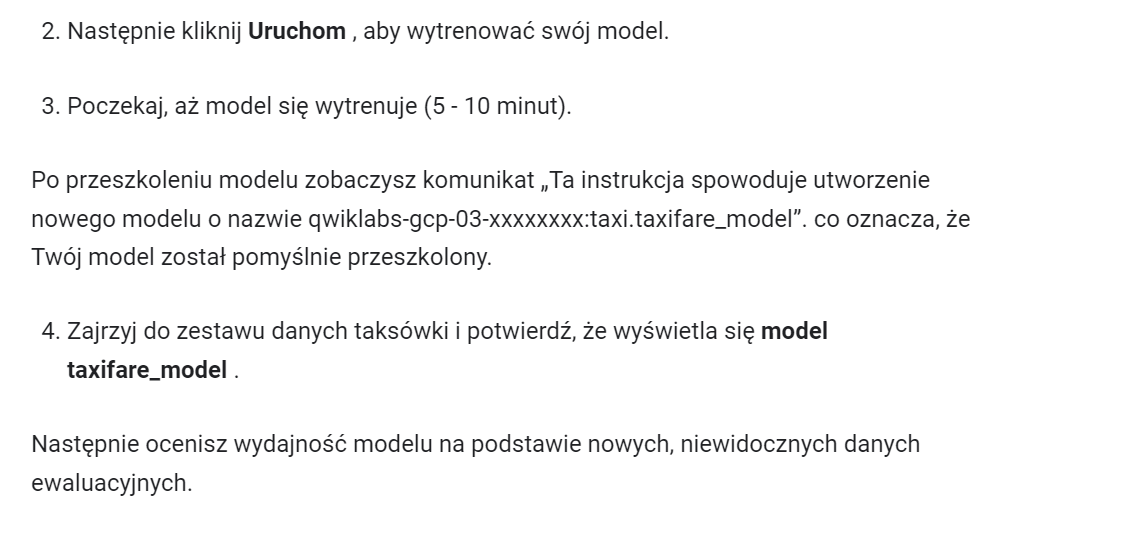

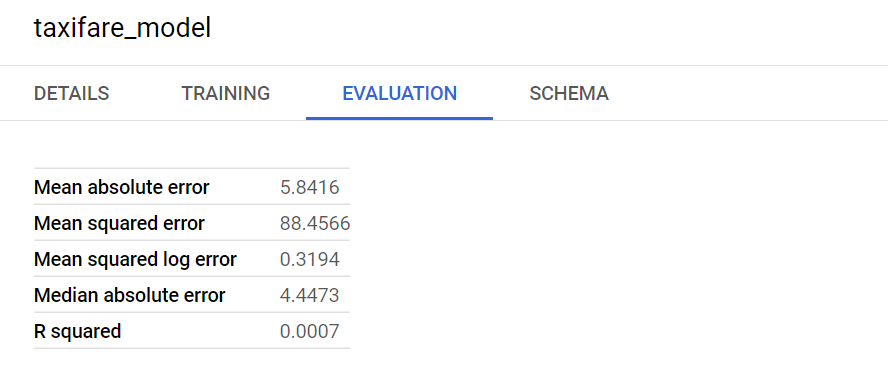

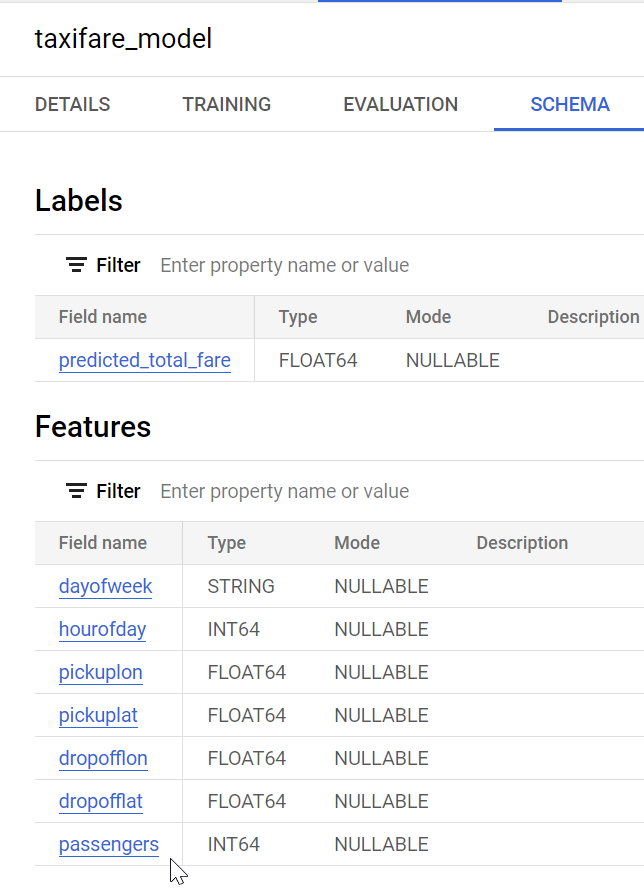

#Zadanie 6. Oceń wydajność modelu klasyfikacyjnego

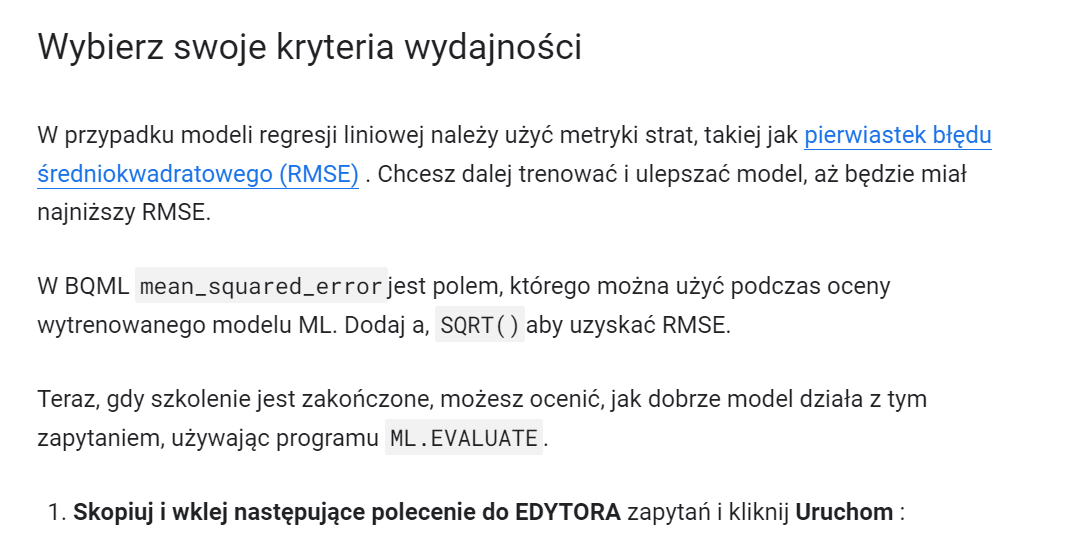

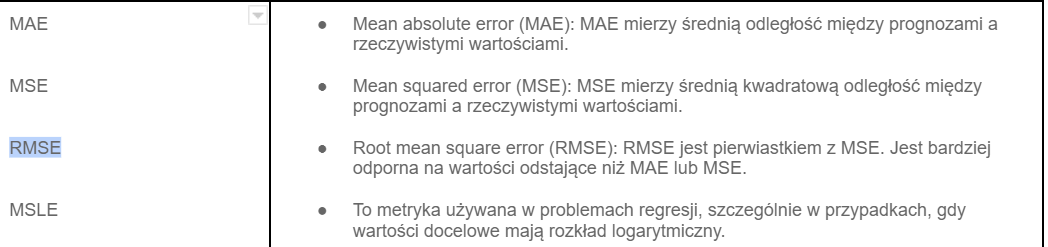

In [ ]:
# SQRT(mean_squared_error)

In [ ]:
%%bigquery

#standardSQL
SELECT
  SQRT(mean_squared_error) AS rmse # 9,47USD
FROM
  ML.EVALUATE(MODEL taxi.taxifare_model,
  (
  WITH params AS (
    SELECT
    1 AS TRAIN,
    2 AS EVAL
    ),
  daynames AS
    (SELECT ['Sun', 'Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat'] AS daysofweek),
  taxitrips AS (
  SELECT
    (tolls_amount + fare_amount) AS total_fare,
    daysofweek[ORDINAL(EXTRACT(DAYOFWEEK FROM pickup_datetime))] AS dayofweek,
    EXTRACT(HOUR FROM pickup_datetime) AS hourofday,
    pickup_longitude AS pickuplon,
    pickup_latitude AS pickuplat,
    dropoff_longitude AS dropofflon,
    dropoff_latitude AS dropofflat,
    passenger_count AS passengers
  FROM
    `nyc-tlc.yellow.trips`, daynames, params
  WHERE
    trip_distance > 0 AND fare_amount > 0

    # Teraz oceniasz model pod kątem innego zestawu przejazdów taksówką za pomocą params.EVALfiltra
    AND MOD(ABS(FARM_FINGERPRINT(CAST(pickup_datetime AS STRING))),1000) = params.EVAL
  )
  SELECT *
  FROM taxitrips
  ))

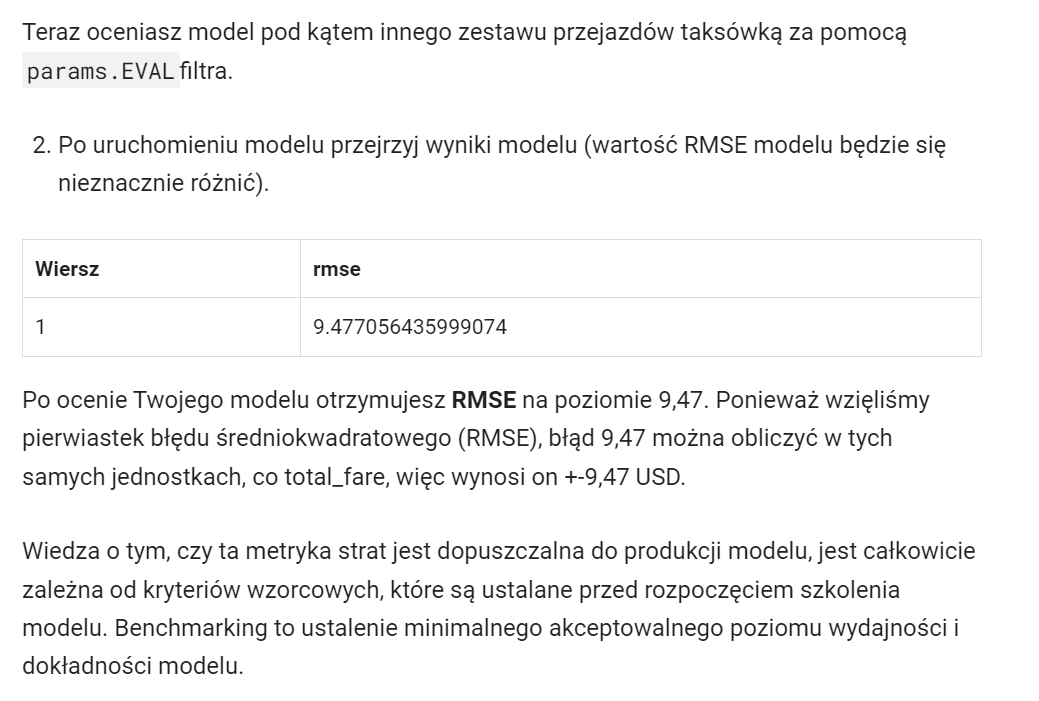

#Zadanie 7. Przewiduj wysokość opłaty za przejazd taksówką

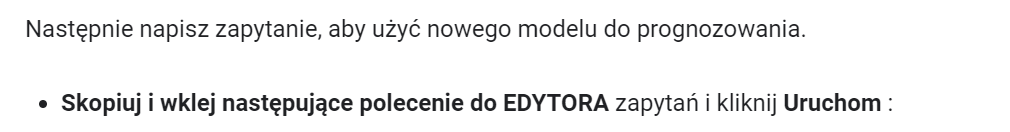

In [ ]:
%%bigquery

SELECT
*
FROM
  ml.PREDICT(MODEL `taxi.taxifare_model`,
   (
 WITH params AS (
    SELECT
    1 AS TRAIN,
    2 AS EVAL
    ),
  daynames AS
    (SELECT ['Sun', 'Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat'] AS daysofweek),
  taxitrips AS (
  SELECT
    (tolls_amount + fare_amount) AS total_fare,
    daysofweek[ORDINAL(EXTRACT(DAYOFWEEK FROM pickup_datetime))] AS dayofweek,
    EXTRACT(HOUR FROM pickup_datetime) AS hourofday,
    pickup_longitude AS pickuplon,
    pickup_latitude AS pickuplat,
    dropoff_longitude AS dropofflon,
    dropoff_latitude AS dropofflat,
    passenger_count AS passengers
  FROM
    `nyc-tlc.yellow.trips`, daynames, params
  WHERE
    trip_distance > 0 AND fare_amount > 0
    AND MOD(ABS(FARM_FINGERPRINT(CAST(pickup_datetime AS STRING))),1000) = params.EVAL
  )
  SELECT *
  FROM taxitrips
));

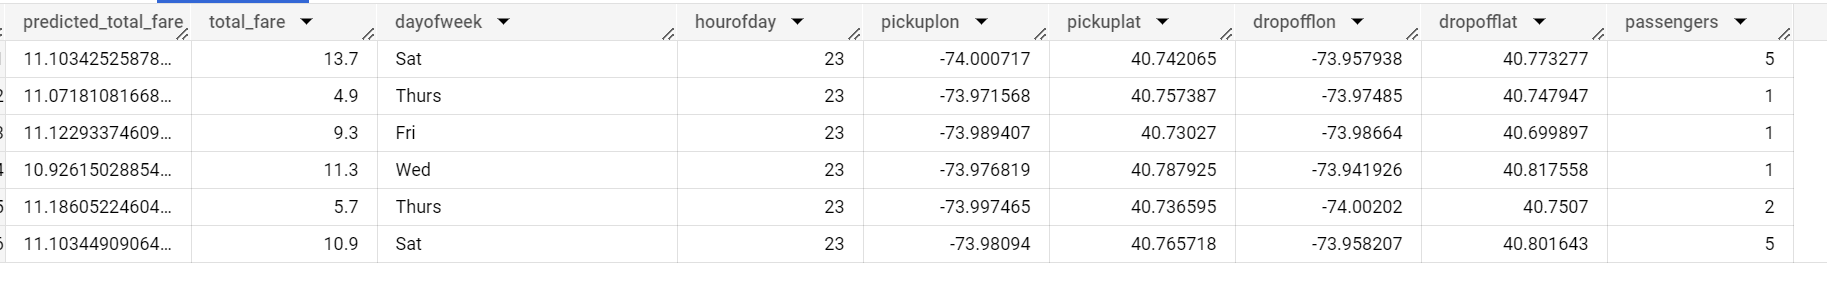

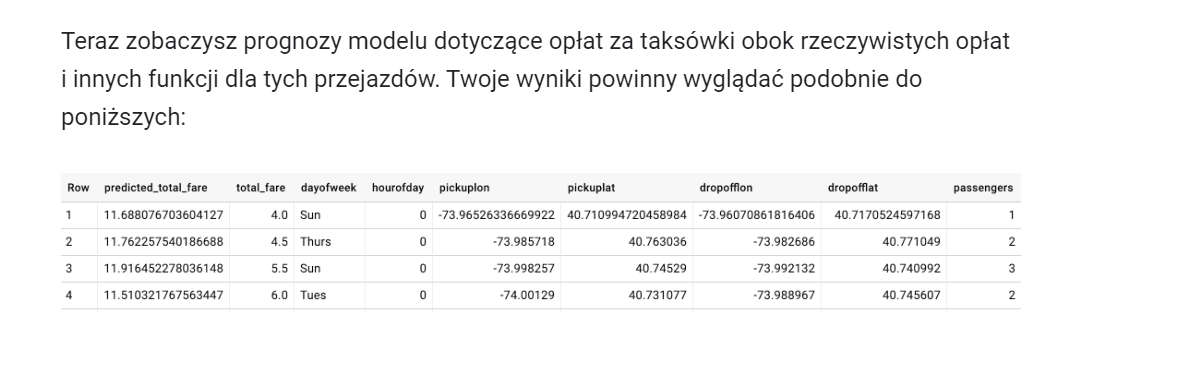

#Zadanie 8. Udoskonalanie modelu za pomocą inżynierii cech

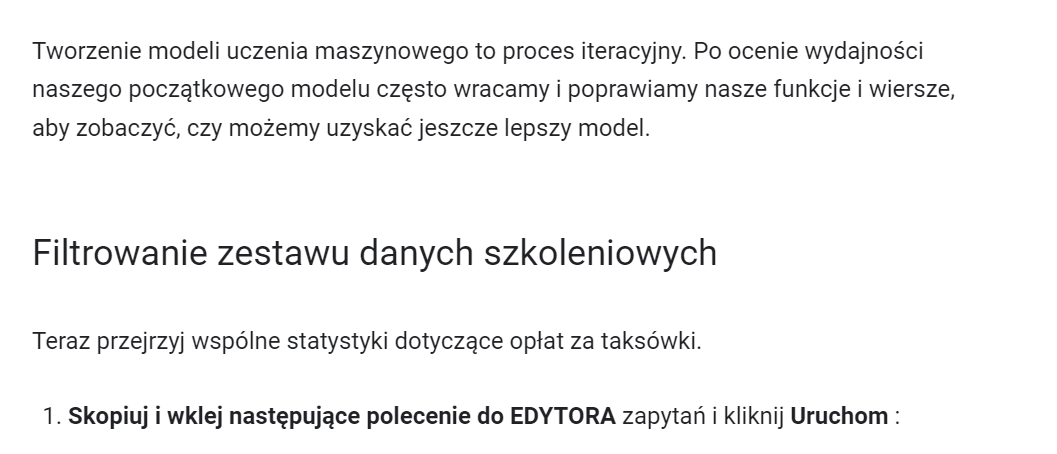

In [ ]:
%%bigquery

SELECT
  COUNT(fare_amount) AS num_fares,
  MIN(fare_amount) AS low_fare,
  MAX(fare_amount) AS high_fare,
  AVG(fare_amount) AS avg_fare,
  STDDEV(fare_amount) AS stddev
FROM
`nyc-tlc.yellow.trips`
# 1,108,779,463 fares

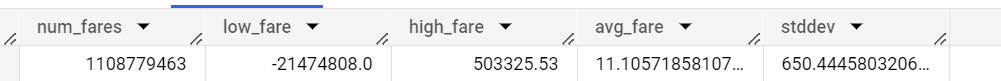

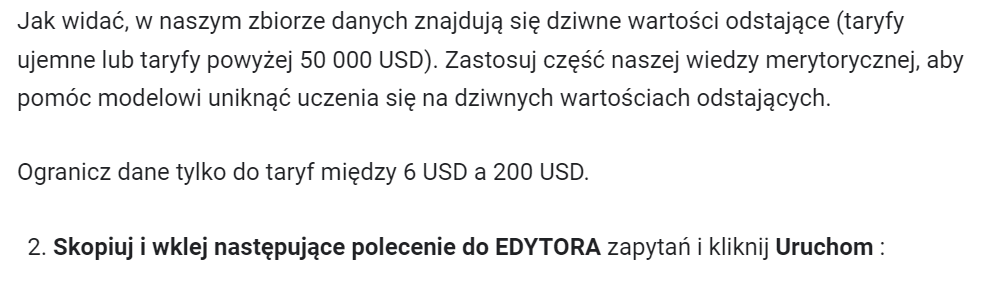

In [ ]:
%%bigquery

SELECT
  COUNT(fare_amount) AS num_fares,
  MIN(fare_amount) AS low_fare,
  MAX(fare_amount) AS high_fare,
  AVG(fare_amount) AS avg_fare,
  STDDEV(fare_amount) AS stddev
FROM
`nyc-tlc.yellow.trips`
WHERE trip_distance > 0 AND fare_amount BETWEEN 6 and 200
# 843,834,902 fares

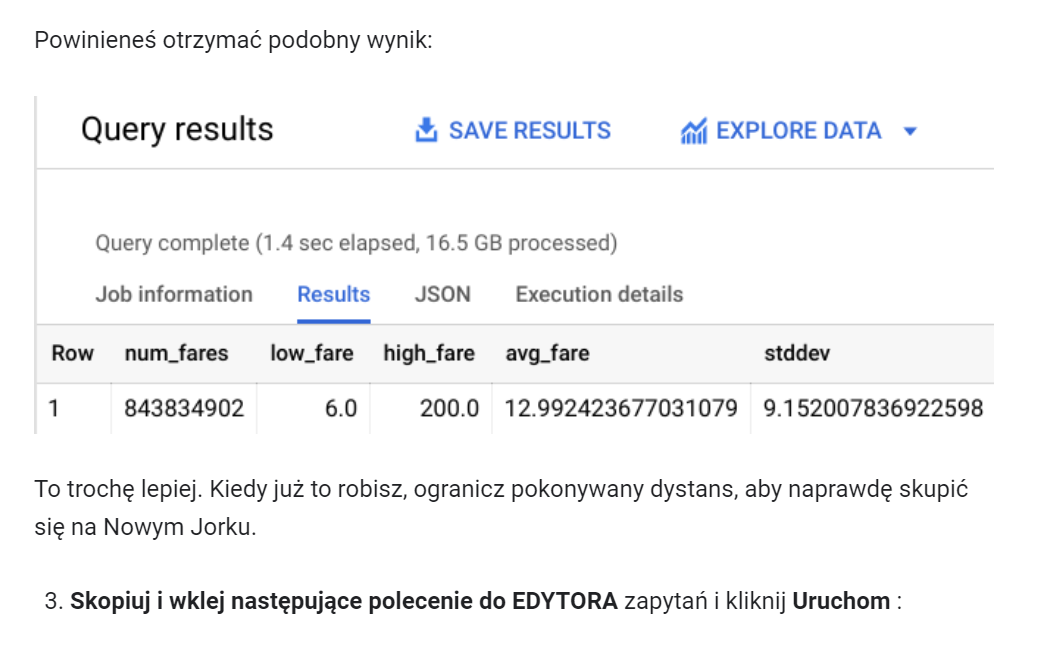

In [ ]:
%%bigquery

SELECT
  COUNT(fare_amount) AS num_fares,
  MIN(fare_amount) AS low_fare,
  MAX(fare_amount) AS high_fare,
  AVG(fare_amount) AS avg_fare,
  STDDEV(fare_amount) AS stddev
FROM
`nyc-tlc.yellow.trips`
WHERE trip_distance > 0 AND fare_amount BETWEEN 6 and 200
    AND pickup_longitude > -75 #limiting of the distance the taxis travel out
    AND pickup_longitude < -73
    AND dropoff_longitude > -75
    AND dropoff_longitude < -73
    AND pickup_latitude > 40
    AND pickup_latitude < 42
    AND dropoff_latitude > 40
    AND dropoff_latitude < 42
    # 827,365,869 fares

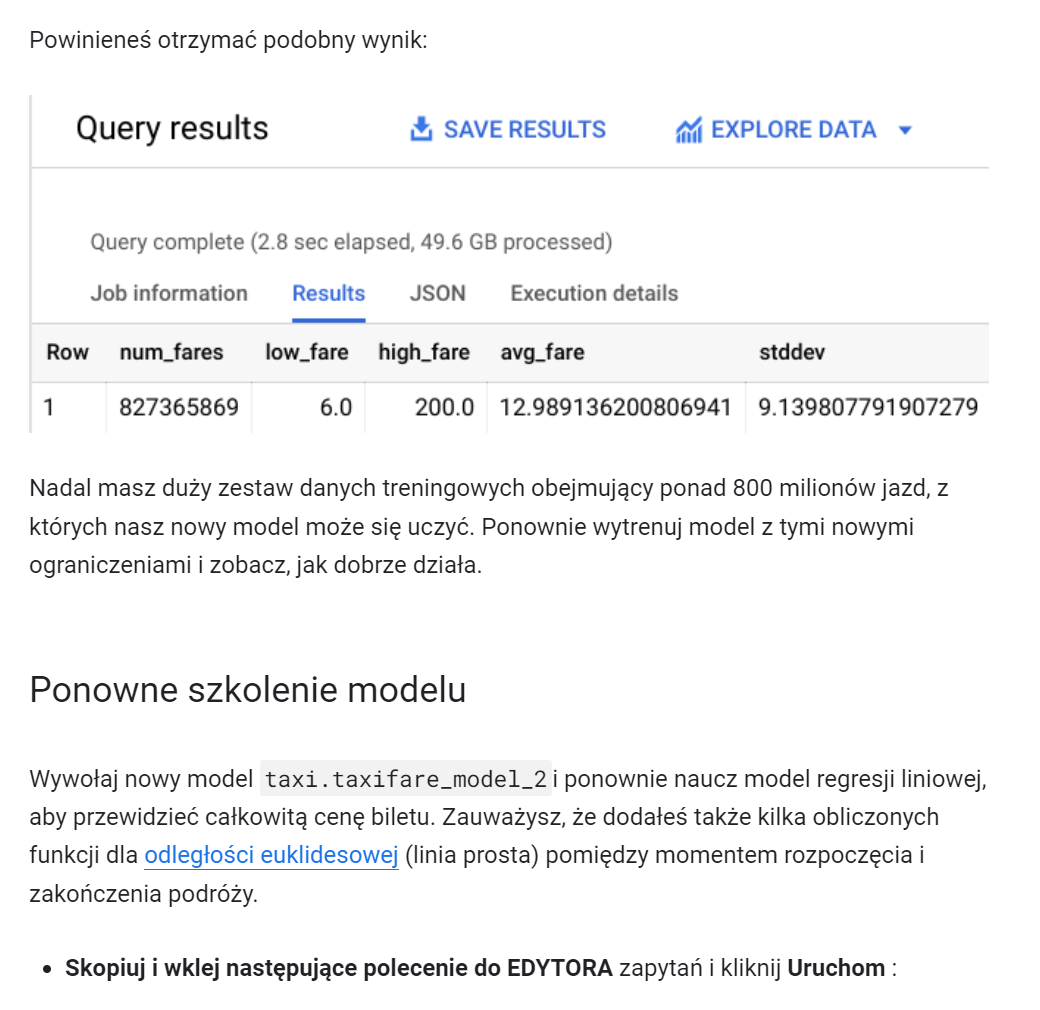

In [ ]:
%%bigquery

CREATE OR REPLACE MODEL taxi.taxifare_model_2
OPTIONS
  (model_type='linear_reg', labels=['total_fare']) AS

WITH params AS (
    SELECT
    1 AS TRAIN,
    2 AS EVAL
    ),

  daynames AS
    (SELECT ['Sun', 'Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat'] AS daysofweek),

  taxitrips AS (
  SELECT
    (tolls_amount + fare_amount) AS total_fare,
    daysofweek[ORDINAL(EXTRACT(DAYOFWEEK FROM pickup_datetime))] AS dayofweek,
    EXTRACT(HOUR FROM pickup_datetime) AS hourofday,
    SQRT(POW((pickup_longitude - dropoff_longitude),2) + POW(( pickup_latitude - dropoff_latitude), 2)) as dist, #Euclidean distance between pickup and drop off
    SQRT(POW((pickup_longitude - dropoff_longitude),2)) as longitude, #Euclidean distance between pickup and drop off in longitude
    SQRT(POW((pickup_latitude - dropoff_latitude), 2)) as latitude, #Euclidean distance between pickup and drop off in latitude
    passenger_count AS passengers
  FROM
    `nyc-tlc.yellow.trips`, daynames, params
WHERE trip_distance > 0 AND fare_amount BETWEEN 6 and 200
    AND pickup_longitude > -75 #limiting of the distance the taxis travel out
    AND pickup_longitude < -73
    AND dropoff_longitude > -75
    AND dropoff_longitude < -73
    AND pickup_latitude > 40
    AND pickup_latitude < 42
    AND dropoff_latitude > 40
    AND dropoff_latitude < 42
    AND MOD(ABS(FARM_FINGERPRINT(CAST(pickup_datetime AS STRING))),1000) = params.TRAIN
  )
  SELECT *
  FROM taxitrips

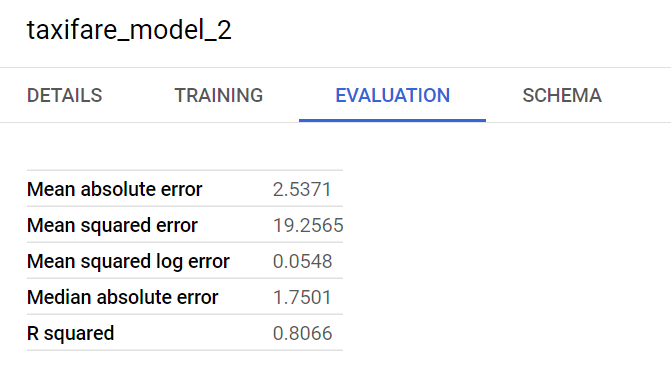

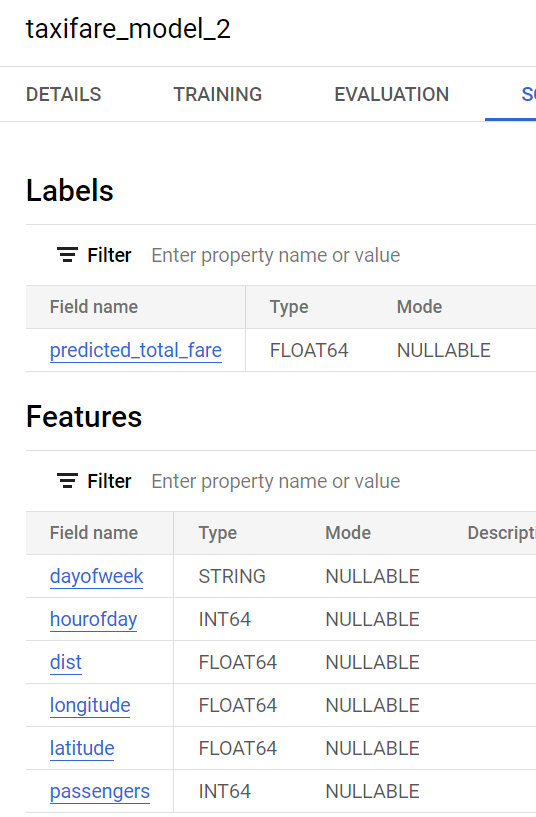

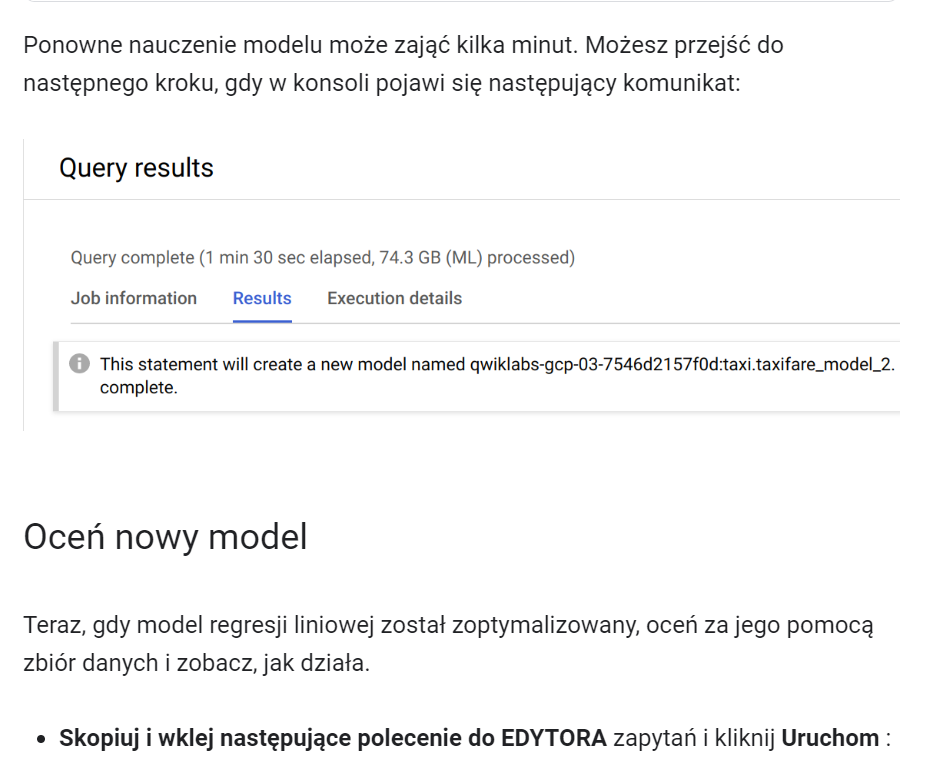

In [ ]:
%%bigquery

SELECT
  SQRT(mean_squared_error) AS rmse
FROM
  ML.EVALUATE(MODEL taxi.taxifare_model_2,
  (
  WITH params AS (
    SELECT
    1 AS TRAIN,
    2 AS EVAL
    ),
  daynames AS
    (SELECT ['Sun', 'Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat'] AS daysofweek),
  taxitrips AS (
  SELECT
    (tolls_amount + fare_amount) AS total_fare,
    daysofweek[ORDINAL(EXTRACT(DAYOFWEEK FROM pickup_datetime))] AS dayofweek,
    EXTRACT(HOUR FROM pickup_datetime) AS hourofday,
    SQRT(POW((pickup_longitude - dropoff_longitude),2) + POW(( pickup_latitude - dropoff_latitude), 2)) as dist, #Euclidean distance between pickup and drop off
    SQRT(POW((pickup_longitude - dropoff_longitude),2)) as longitude, #Euclidean distance between pickup and drop off in longitude
    SQRT(POW((pickup_latitude - dropoff_latitude), 2)) as latitude, #Euclidean distance between pickup and drop off in latitude
    passenger_count AS passengers
  FROM
    `nyc-tlc.yellow.trips`, daynames, params
WHERE trip_distance > 0 AND fare_amount BETWEEN 6 and 200
    AND pickup_longitude > -75 #limiting of the distance the taxis travel out
    AND pickup_longitude < -73
    AND dropoff_longitude > -75
    AND dropoff_longitude < -73
    AND pickup_latitude > 40
    AND pickup_latitude < 42
    AND dropoff_latitude > 40
    AND dropoff_latitude < 42
    AND MOD(ABS(FARM_FINGERPRINT(CAST(pickup_datetime AS STRING))),1000) = params.EVAL
  )
  SELECT *
  FROM taxitrips
  ))

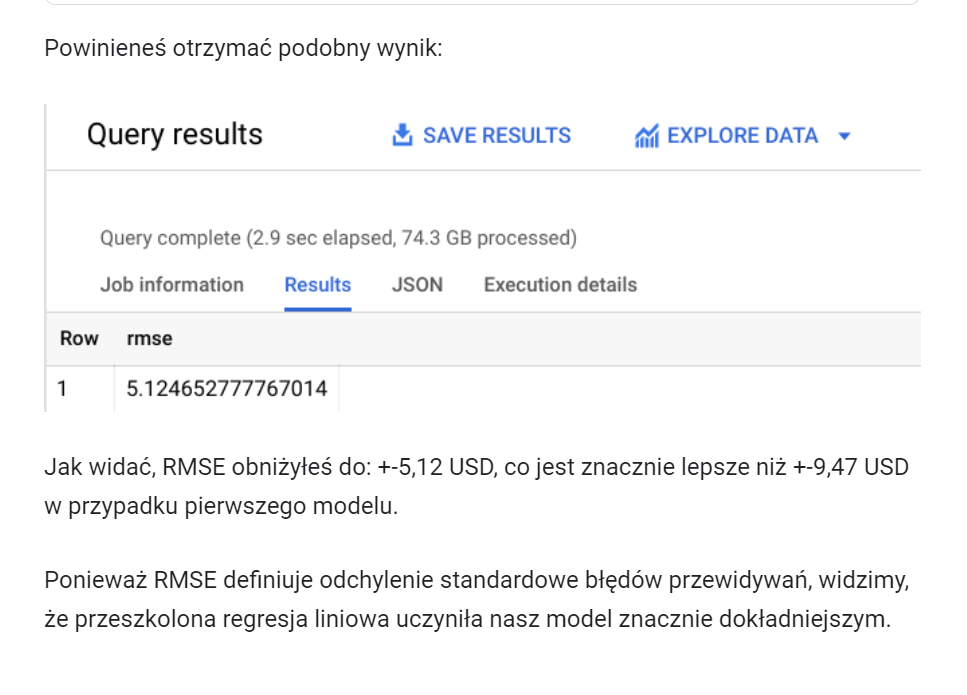

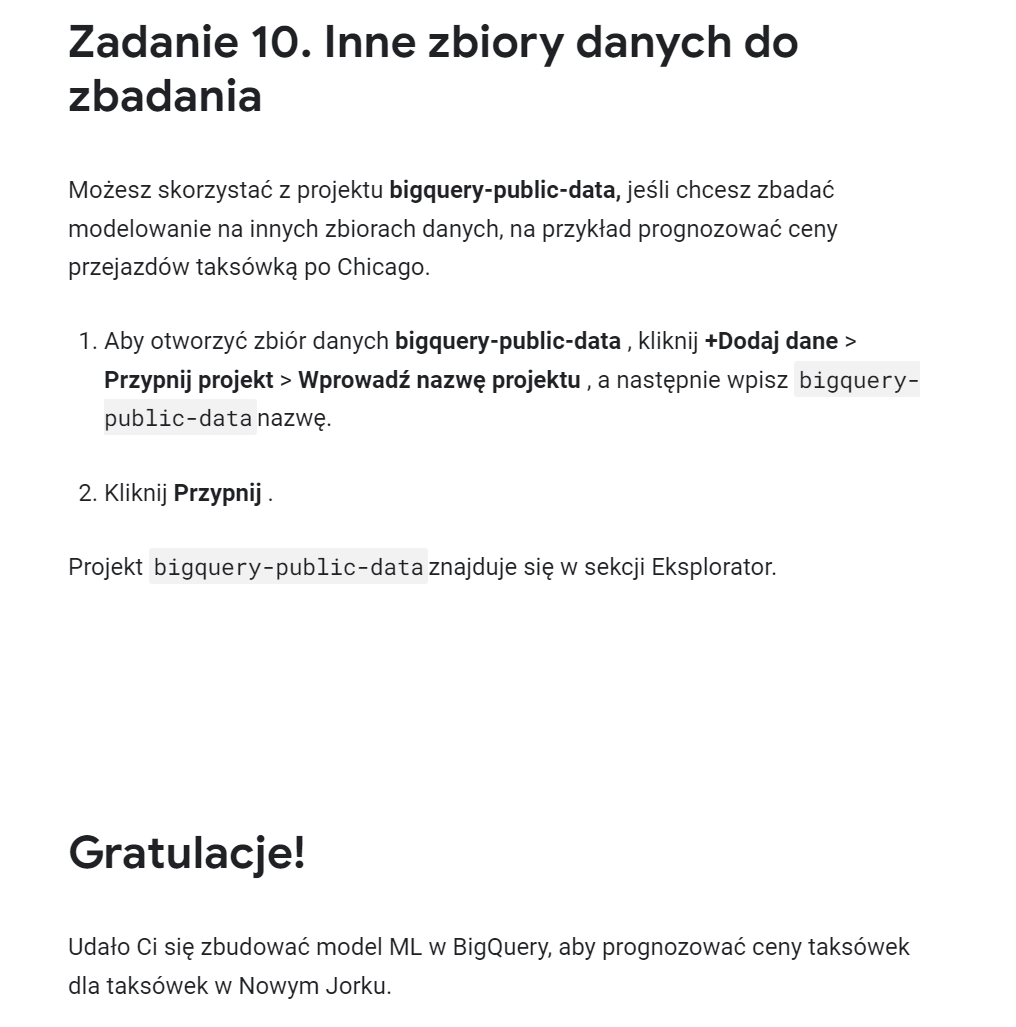